# Cohort Case Study 2

This notebook will follow a similar approach to what was done in the notebook ``Cohort Case Study 1``, but this time we'll use a real dataset. Since this time we're handling a real dataset, it might not be obvious which cohorts follow different behaviors, as we've seen in the aforementioned notebook.

We'll start by downloading the dataset and reading the train and test sets.

In [237]:
import sys
sys.path.append('../../../notebooks')

import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from raimitigations.utils import split_data, fetch_cohort_results
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager
from download import download_datasets

SEED = 46
#SEED = None

np.random.seed(SEED)
random.seed(SEED)

data_dir = "../../../datasets/census/"
download_datasets(data_dir)

label_col = "income"
df_train = pd.read_csv(data_dir + "train.csv")
df_test = pd.read_csv(data_dir + "test.csv")
# convert to 0 and 1 encoding
df_train[label_col] = df_train[label_col].apply(lambda x: 0 if x == "<=50K" else 1)
df_test[label_col] = df_test[label_col].apply(lambda x: 0 if x == "<=50K" else 1)

X_train = df_train.drop(columns=[label_col])
y_train = df_train[label_col]
X_test = df_test.drop(columns=[label_col])
y_test = df_test[label_col]

In [238]:
print(df_train.shape)
print(df_test.shape)

(32561, 15)
(16281, 15)


In [239]:
df_train

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,0,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,0,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,1,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,0,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,0,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


Here we define which model will be used throughout the experiments performed here. Remember that our goal is not to compare different models, but instead to compare different approaches to cohort processing. Therefore, we'll use the same model for all experiments, but we'll alternate between training a pipeline using the entire dataset and training multiple pipelines, where each pipeline is associated with a specific cohort. We'll also see how the cohort definition changes the results obtained.

In [240]:
def get_model():
    model = LGBMClassifier(random_state=SEED)
    #model = LogisticRegression()
    return model

## Initial analysis of multiple cohort definitions

Now that we have our dataset, we can create a simple pipeline and fit it using the training data. We'll then use the ``fetch_cohort_results`` function to show the results obtained for the entire dataset, as well as for different cohorts. Notice that this function computes all metrics for each cohort separately, and therefore, different thresholds might be encountered for each cohort (the optimal threshold of a given set of predictions is found using the ROC curve).

### Superficial analysis of the "race" cohorts

Our first analysis will focus on the cohorts defined by the ``race`` feature.

In [241]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["race"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.928045,0.214291,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`race` == "" Amer-Indian-Eskimo"")",159,0.964286,0.236285,0.760706,0.916541,0.807547,0.893082
2,cohort_1,"(`race` == "" Asian-Pac-Islander"")",480,0.904596,0.209811,0.777669,0.830903,0.789716,0.812500
3,cohort_2,"(`race` == "" Black"")",1561,0.950497,0.098247,0.706862,0.886423,0.744534,0.846252
4,cohort_3,"(`race` == "" Other"")",135,0.980000,0.176354,0.895238,0.952727,0.920085,0.948148
5,cohort_4,"(`race` == "" White"")",13946,0.924495,0.235332,0.776855,0.840369,0.793715,0.824896


Let's now create a separate pipeline for the different cohorts, instead of training a single pipeline for the entire dataset. We'll accomplish this by using the ``CohortManager`` class. We'll then compare the results obtained for the same cohorts tested in the previous cell. In this notebook, just like in ``Cohort Case Study 1``, we'll call this approach the cohort-based pipeline, and we'll try different cohort-based pipelines, each time using different cohort definitions.

In [242]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["race"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["race"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.919545,0.212255,0.769716,0.839667,0.788366,0.824765
1,cohort_0,"(`race` == "" Amer-Indian-Eskimo"")",159,0.722932,0.003494,0.578701,0.683083,0.471853,0.522013
2,cohort_1,"(`race` == "" Asian-Pac-Islander"")",480,0.881606,0.133196,0.763607,0.809787,0.775563,0.802083
3,cohort_2,"(`race` == "" Black"")",1561,0.920955,0.022147,0.675330,0.858043,0.699228,0.804612
4,cohort_3,"(`race` == "" Other"")",135,0.826545,0.006283,0.670588,0.763636,0.676923,0.740741
5,cohort_4,"(`race` == "" White"")",13946,0.924379,0.212255,0.772555,0.841171,0.788055,0.817510


Notice that using a separate pipeline for each cohort defined by the ``race`` column is not a good idea: we got considerably worse results for some cohorts compared to the baseline pipeline. This might mean that, for some cohorts (like cohort ``cohort_0``), we have insufficient data for training a separate model for that cohort, and that the data from other cohorts indeed helps the end result. This could also mean that these cohorts share similarities to other cohorts, and that is why using data from different cohorts to train a single model is better than training a separate model for each cohort.

### Superficial analysis of the "gender" cohorts

Let's now try other cohort definitions and see if we can find some scenario where the model underperforms for a given cohort. Our next test is to check the cohorts defined by the ``gender`` column. We'll follow the same procedure: first, we train a single pipeline over the entire dataset, followed by an evaluation of the predictions over the test data separated by each cohort. Once again, the metrics are computed separately for the predictions of each cohort, and therefore, we might see different optimal threshold values encountered for different cohorts.

In [223]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.928045,0.214291,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`gender` == "" Female"")",5421,0.945489,0.077829,0.697068,0.866671,0.734840,0.848552
2,cohort_1,"(`gender` == "" Male"")",10860,0.910614,0.284180,0.780929,0.821125,0.790895,0.809761


Next, we create different pipelines for each cohort and evaluate the predictions made by the ensemble of models over each cohort separately.

In [224]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["gender"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.924731,0.224417,0.771722,0.841294,0.790623,0.826976
1,cohort_0,"(`gender` == "" Female"")",5421,0.939232,0.100605,0.726703,0.867672,0.769103,0.880834
2,cohort_1,"(`gender` == "" Male"")",10860,0.908182,0.306261,0.784077,0.818615,0.794710,0.815838


Analyzing the two previous results, we can notice that there isn't a considerable difference in the metrics for each of the cohorts. Also, training different pipelines for each cohort didn't manage to improve the performance, just like our previous results. Therefore, it seems that the cohorts defined by the ``gender`` column follow similar behaviors, so we won't be able to gain a lot using different pipelines for each cohort in this case.

### Superficial analysis of the "relationship" cohorts

We now analyze the cohorts defined by the ``relationship`` column. Let's see the results of the baseline pipeline over each of these cohorts:

In [225]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.928045,0.214291,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.851455,0.496800,0.767644,0.760808,0.762712,0.767745
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.903658,0.078964,0.648626,0.823863,0.672058,0.806685
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.936405,0.034834,0.574932,0.890196,0.588954,0.849524
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.933263,0.011240,0.545761,0.884905,0.540163,0.839634
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.908060,0.054493,0.597355,0.833168,0.610507,0.811793
6,cohort_5,"(`relationship` == "" Wife"")",763,0.873899,0.492120,0.792793,0.794374,0.793273,0.794233


As we can see, in this case, we do have some cohorts that have considerably worse results than others. For example, cohorts ``cohort_2``, ``cohort_3``, and ``cohort_4`` have considerably lower F1 scores than the other cohorts. This could be a problem if the ``relationship`` column is considered a sensitive feature, where a similar performance is expected for all cohorts. In that case, we'll see if we can improve the metrics for these cohorts using different pipelines for each cohort, similar to what we've done in the previous experiments:

In [226]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.921740,0.235577,0.774480,0.838504,0.793696,0.831767
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.847310,0.496186,0.768719,0.761313,0.763310,0.768511
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.894365,0.076893,0.652406,0.815078,0.679824,0.819542
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.904314,0.000759,0.574198,0.862745,0.591053,0.859048
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.000762,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.872706,0.030138,0.603854,0.799634,0.629067,0.846337
6,cohort_5,"(`relationship` == "" Wife"")",763,0.830681,0.438196,0.749464,0.751278,0.748091,0.748362


Notice that this time, training different pipelines for the cohorts defined by the ``relationship`` column resulted in considerable improvements in some cohorts, while also attaining slightly worse results in other cohorts. We can see that the F1 score for ``cohort_3`` got improved, but at the same time, for this same cohort, the AUC ROC went down a bit. For ``cohort_5``, the AUC ROC and F1 scores were lower when training different pipelines. This might indicate that training a separate model for ``cohort_3`` and another model for the remaining cohorts might result in a better result. We'll explore this in the following cells.

## A Closer Look at the "relationship" cohorts

In this section, we'll take a closer look at how we can try to improve the results for the cohorts defined by the ``relationship`` column. As we've shown, this set of cohorts does present some considerably different metrics between different cohorts. Here we'll try using different cohort definitions, and data rebalancing to improve the performance over a set of cohorts.

Before starting the analysis, we'll create a function for plotting the label distribution over different cohorts. This will be useful when we start looking at data imbalance.

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1) 
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

We can now look at the label distribution over each of the ``relationship`` cohorts using the function previously defined (with the help of the ``CohortManager`` class):

0    24720
1     7841
Name: income, dtype: int64

cohort_0:
0    7275
1    5918
Name: income, dtype: int64
***********

cohort_1:
0    7449
1     856
Name: income, dtype: int64
***********

cohort_2:
0    944
1     37
Name: income, dtype: int64
***********

cohort_3:
0    5001
1      67
Name: income, dtype: int64
***********

cohort_4:
0    3228
1     218
Name: income, dtype: int64
***********

cohort_5:
0    823
1    745
Name: income, dtype: int64
***********


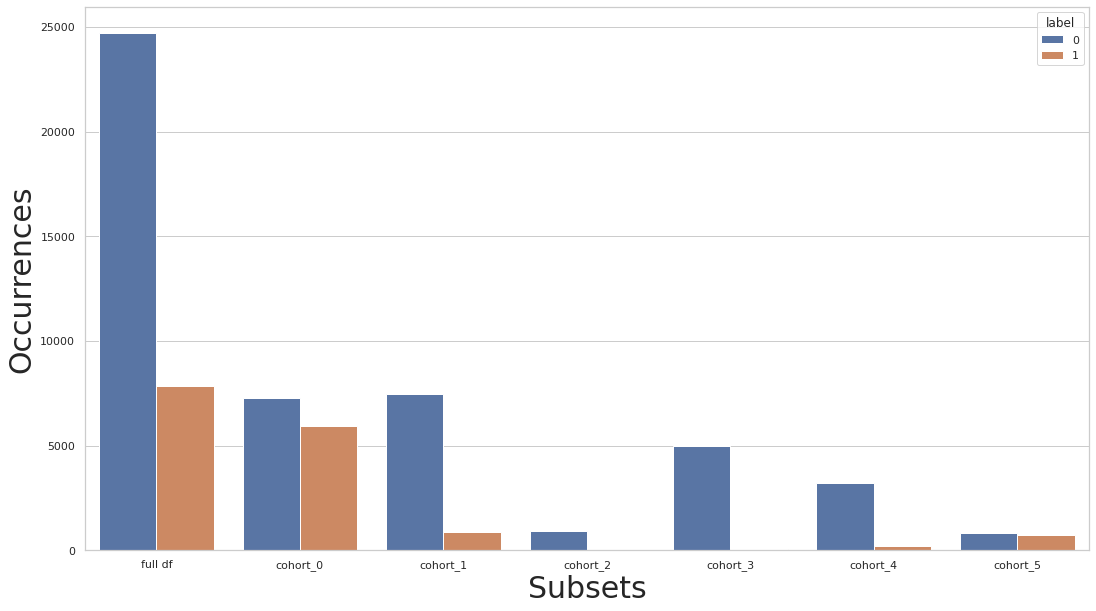

In [228]:
cohort_set = CohortManager(
    cohort_col=["relationship"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

### Rebalancing the entire dataset

Let's start by using a simple rebalance strategy using the ``Rebalance`` class over the entire dataset. We then plot the new label distributions:

0    24720
1    24720
Name: income, dtype: int64

cohort_0:
1    21603
0     7275
Name: income, dtype: int64
***********

cohort_1:
0    7449
1    1423
Name: income, dtype: int64
***********

cohort_2:
0    944
1     40
Name: income, dtype: int64
***********

cohort_3:
0    5001
1      77
Name: income, dtype: int64
***********

cohort_4:
0    3228
1     238
Name: income, dtype: int64
***********

cohort_5:
1    1339
0     823
Name: income, dtype: int64
***********


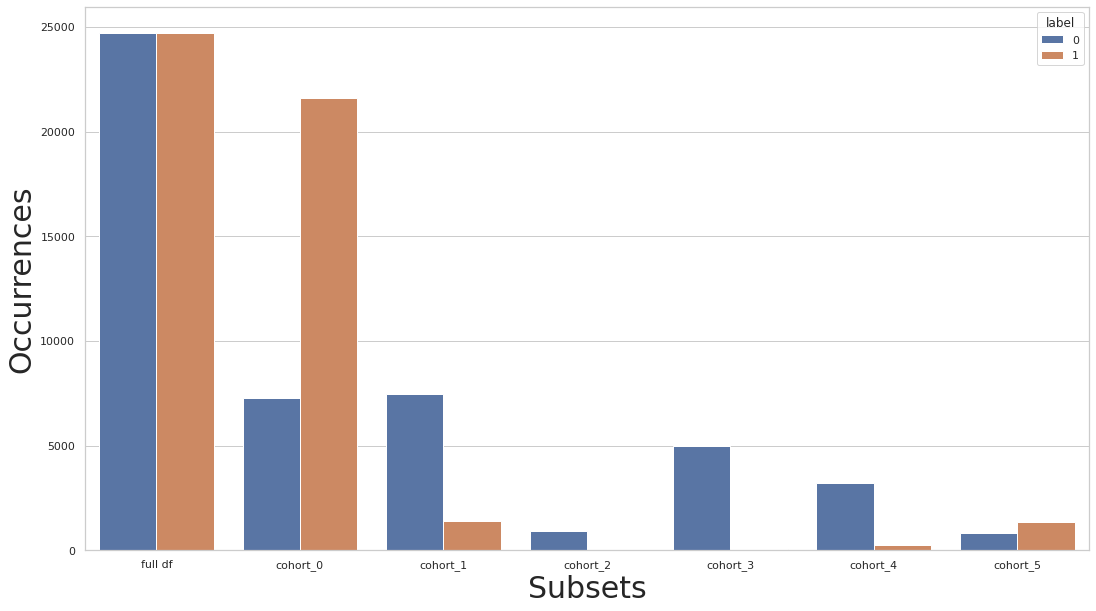

In [229]:
rebalance = dp.Rebalance(verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set.fit(X=new_X_train, y=new_y_train)
subsets = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

print(new_y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

Notice that the label distribution became imbalanced towards the opposite class in ``cohort_0`` after rebalancing. Let's now use the baseline pipeline with the rebalanced dataset and check the results for the ``relationship`` cohorts:

In [230]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.921874,0.285999,0.765679,0.836890,0.783717,0.819974
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.835034,0.605171,0.750890,0.750629,0.750755,0.753488
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.899895,0.138539,0.684344,0.829142,0.722082,0.860215
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.953791,0.045129,0.586376,0.901961,0.612290,0.872381
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.932081,0.017004,0.557454,0.874103,0.572312,0.884202
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.903355,0.042936,0.583324,0.828068,0.574734,0.762954
6,cohort_5,"(`relationship` == "" Wife"")",763,0.861501,0.548571,0.782269,0.784459,0.781979,0.782438


As expected, we didn't have a considerable improvement for some cohorts. For example, let's focus here on ``cohort_3``, which presented considerably worse results when compared to the other cohorts when using the baseline pipeline over the original dataset. For this cohort, after rebalancing, the baseline pipeline resulted in inferior precision and recall metrics when compared to the results obtained by the baseline pipeline trained over the original dataset. This makes sense because only a very small number of instances were created for ``cohort_3`` after the rebalancing operation, which is a result of how SMOTE works. Therefore, we now have a greater imbalance in the number of instances in each cohort, which may result in inferior results for these minority cohorts.

We'll now try using the cohort-based pipeline over the rebalanced dataset:

In [231]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.917939,0.339383,0.777103,0.834813,0.796039,0.836005
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.831617,0.537313,0.742007,0.744544,0.741650,0.742450
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.900655,0.106587,0.662199,0.810464,0.694328,0.838008
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.905359,0.001583,0.593400,0.879412,0.627154,0.891429
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.918816,0.000918,0.606111,0.872008,0.655795,0.945881
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.881868,0.021182,0.597508,0.817802,0.614191,0.821918
6,cohort_5,"(`relationship` == "" Wife"")",763,0.835875,0.594278,0.760932,0.761051,0.760990,0.762779


The results shown above depict a similar scenario to the previous results (baseline pipeline over the rebalanced dataset): an improvement over some cohorts and performance reduction for other cohorts. Once again, this is because a different number of data points were added to each cohort, due to the nature of the SMOTE rebalancing technique (used in the ``Rebalance`` class).

### Rebalancing only a few cohorts

Let's try to mitigate these issues by rebalancing only a few cohorts because as we've seen in the label distribution of the original dataset, only a few cohorts have a serious label imbalance. This way, we'll try to improve the results of only a few cohorts. In the following cell, we use the ``Rebalance`` class together with the ``CohortManager`` in order to rebalance only cohorts ``cohort_2`` and ``cohort_3``:

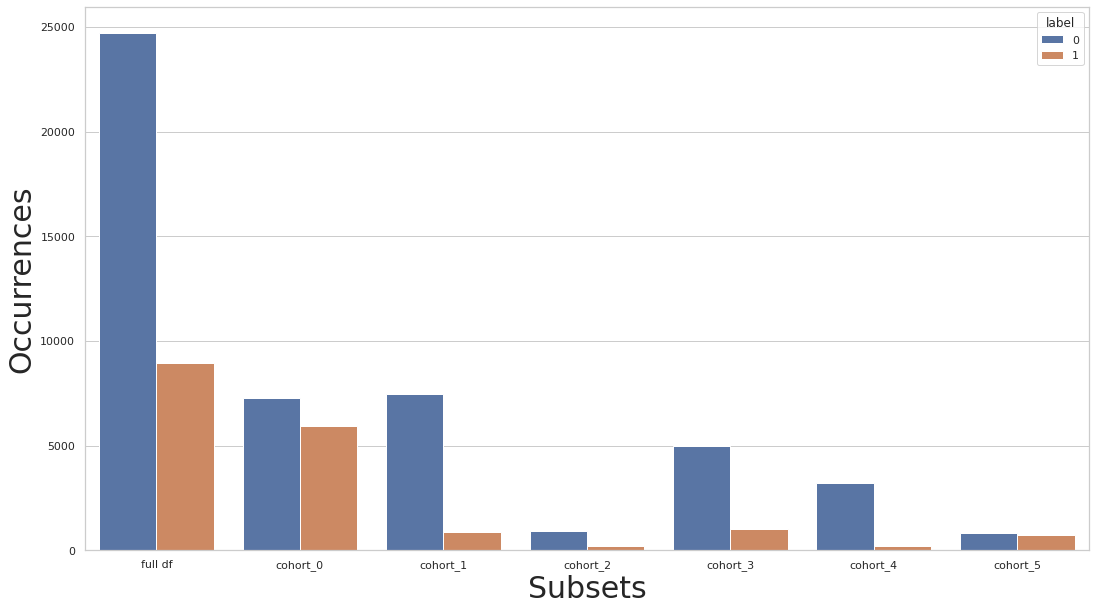

In [232]:
c0_pipe = []
c1_pipe = []
c2_pipe = [dp.Rebalance(strategy_over=0.2, verbose=False)]
c3_pipe = [dp.Rebalance(strategy_over=0.2, verbose=False)]
c4_pipe = []
c5_pipe = []

rebalance_cohort = CohortManager(
    transform_pipe=[c0_pipe, c1_pipe, c2_pipe, c3_pipe, c4_pipe, c5_pipe],
    cohort_col=["relationship"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

We'll now repeat the same experiments as before. We'll first train the baseline pipeline over the new rebalanced dataset:

In [233]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.922955,0.243259,0.766493,0.839125,0.784462,0.820097
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.849175,0.513855,0.770341,0.759717,0.762100,0.768358
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.900467,0.131611,0.657451,0.818966,0.687095,0.826554
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.949020,0.111778,0.585294,0.900980,0.610194,0.870476
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.920128,0.076464,0.552481,0.858689,0.562234,0.875846
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.905372,0.040851,0.576866,0.816418,0.558062,0.740917
6,cohort_5,"(`relationship` == "" Wife"")",763,0.870593,0.489399,0.786184,0.787654,0.786651,0.787680


Once again, we did get improvements for some cohorts, and performance reduction for others. Let's try using the cohort-based pipeline over this new rebalanced dataset:

In [234]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.921497,0.235577,0.772831,0.837936,0.791930,0.829802
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.847310,0.496186,0.768719,0.761313,0.763310,0.768511
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.894365,0.076893,0.652406,0.815078,0.679824,0.819542
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.888235,0.006322,0.595128,0.851961,0.631201,0.900952
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.902776,0.001906,0.536897,0.839271,0.518907,0.815758
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.872706,0.030138,0.603854,0.799634,0.629067,0.846337
6,cohort_5,"(`relationship` == "" Wife"")",763,0.830681,0.438196,0.749464,0.751278,0.748091,0.748362


Let's compare this last results with the results obtained by using the cohort-base pipeline over the original dataset: by using the rebalanced dataset, we managed to improve the performance for ``cohort_2``, but we suffered a performance reduction for ``cohort_3``. This shows us that we must always carefully analyze how the rebalancing process affects each cohort separately. In the following sections, we'll take a closer look at how we can improve the results for ``cohort_3``, since rebalancing didn't work very well for this cohort (although rebalancing worked fine for ``cohort_2``).

### Looking at "cohort_3", where "relationship" == "Own-child"

Let's try training a cohort-based pipeline for the following cohorts: cohort where ``relationship`` == "Own-child", and another cohort for the remaining instances. We'll try this approach because we noticed that training a separate pipeline for ``cohort_3`` did improve its metrics, but the same doesn't apply to the other cohorts, that is, the other cohorts benefit by using data from different cohorts.

In [235]:
c0 = [ ['relationship', '==', [' Own-child']] ]
c1 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.926455,0.226182,0.774861,0.844373,0.794105,0.830170
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.851043,0.513947,0.771036,0.760570,0.762947,0.769125
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.904380,0.097639,0.663575,0.820838,0.695773,0.835671
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.956732,0.027224,0.573529,0.914706,0.581581,0.834286
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.000762,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.907919,0.065474,0.606513,0.826619,0.630507,0.838594
6,cohort_5,"(`relationship` == "" Wife"")",763,0.871434,0.530978,0.800143,0.797383,0.798401,0.800786


If we compare the results above with the results obtained with the cohort-base pipeline (using the ``relationship`` cohorts) over the original dataset, we can see that the former has the best metrics for almost all cohorts. This is because some cohorts work well together, while others (in this case, ``cohort_3``) perform better if trained separately. And thanks to the ``CohortManager``, we managed to do this.

We still haven't managed to improve the results for ``cohort_2``. Similar to what happened to ``cohort_3``, we can test which cohorts work well with ``cohort_2`` and which don't, that is, which cohorts can be trained together, and which cohorts that when trained together result in sub-optimal metrics. After experimenting with a few combinations, we found out that ``cohort_1`` and ``cohort_2`` worked well together: if we train a separate pipeline for a cohort comprised of all instances where ``relationship`` is either "Not-in-family" or "Unmarried", then we manage to improve the metrics for these two cohorts.

In [236]:
c0 = [ ['relationship', '==', [' Own-child']] ]
c1 = [ ['relationship', '==', [' Not-in-family', ' Unmarried']] ]
c2 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16281,0.925274,0.249491,0.778632,0.842644,0.798186,0.835759
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.848288,0.453393,0.760762,0.759740,0.760192,0.763146
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.903614,0.086289,0.662846,0.824587,0.694509,0.832866
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.907974,0.078535,0.614483,0.861765,0.660477,0.920000
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.000762,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.903362,0.050977,0.598105,0.818432,0.615314,0.823109
6,cohort_5,"(`relationship` == "" Wife"")",763,0.876226,0.472902,0.794176,0.796462,0.793824,0.794233
